In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample

from IPython.core.interactiveshell import InteractiveShell

pd.options.display.float_format = '{:,.2f}'.format
InteractiveShell.ast_node_interactivity = "all"

# Get data and pre-process

In [20]:
# Load the historical data into a pandas dataframe
flight_data = pd.read_csv("data/flight_data.csv", parse_dates=['Date (MM/DD/YYYY)'])
origin_weather_data = pd.read_csv("data/origin_weather.csv", parse_dates=['origin_time'])
destination_weather_data = pd.read_csv("data/weather/SYR.csv", parse_dates=['time'])

# Categorize delays
flight_data['Status'] = pd.cut(flight_data['Arrival Delay (Minutes)'],
                               bins=[-np.inf, -10, 10, 30, np.inf],
                               labels=['Early', 'On-time', 'Late', 'Severely Late']
                               )

# Drop unnecessary columns
flight_data.drop(columns=[
    'Flight Number',
    'Tail Number',
    'Scheduled Arrival Time',
    'Scheduled Elapsed Time (Minutes)',
    'Arrival Delay (Minutes)',
    'Wheels-on Time',
    'Taxi-In time (Minutes)',
    'Delay Carrier (Minutes)',
    'Delay Weather (Minutes)',
    'Delay National Aviation System (Minutes)',
    'Delay Security (Minutes)',
    'Delay Late Aircraft Arrival (Minutes)'
], inplace=True)

# Handle missing values
flight_data.dropna(inplace=True)

# Add Arrival Datetime

In [21]:
# Create a boolean mask to identify rows with '24:00:00'
mask_24 = flight_data['Actual Arrival Time'] == '24:00:00'

# Replace '24:00:00' with '00:00:00'
flight_data['Actual Arrival Time'] = flight_data['Actual Arrival Time'].replace('24:00:00', '00:00:00')

# Combine date and time columns
flight_data['Arrival Datetime'] = pd.to_datetime(
    flight_data['Date (MM/DD/YYYY)'].astype(str) + ' ' + flight_data['Actual Arrival Time'])

# Add a day to the date part when the original time value was '24:00:00'
flight_data.loc[mask_24, 'Arrival Datetime'] = flight_data.loc[mask_24, 'Arrival Datetime'] + pd.Timedelta(days=1)

# Show 10 rows of the dataframe
flight_data.head(10)

,Date (MM/DD/YYYY),Origin Airport,Actual Arrival Time,Actual Elapsed Time (Minutes),Status,Arrival Datetime
0,1988-01-01,ORD,19:13,79,Early,1988-01-01 19:13:00
1,1988-01-01,ORD,22:41,95,On-time,1988-01-01 22:41:00
2,1989-01-01,ORD,18:27,89,Severely Late,1989-01-01 18:27:00
3,1989-01-01,ORD,20:55,113,Severely Late,1989-01-01 20:55:00
4,1989-01-01,ORD,9:00,96,On-time,1989-01-01 09:00:00
5,1989-01-01,ORD,23:37,110,Severely Late,1989-01-01 23:37:00
6,1989-01-01,IAD,15:28,120,Severely Late,1989-01-01 15:28:00
7,1989-01-01,IAD,23:39,91,Severely Late,1989-01-01 23:39:00
8,1990-01-01,ORD,16:48,120,Late,1990-01-01 16:48:00
9,1990-01-01,ORD,22:51,100,On-time,1990-01-01 22:51:00


# Add Departure Datetime

In [22]:
# Convert the 'Actual Elapsed Time (Minutes)' to a timedelta
flight_data['Actual Elapsed Time'] = pd.to_timedelta(flight_data['Actual Elapsed Time (Minutes)'], unit='m')

# Subtract the 'Actual Elapsed Time' from the 'Arrival Datetime' to create the 'Departure Datetime' column
flight_data['Departure Datetime'] = flight_data['Arrival Datetime'] - flight_data['Actual Elapsed Time']

# Show 10 rows of the dataframe
flight_data.head(10)

,Date (MM/DD/YYYY),Origin Airport,Actual Arrival Time,Actual Elapsed Time (Minutes),Status,Arrival Datetime,Actual Elapsed Time,Departure Datetime
0,1988-01-01,ORD,19:13,79,Early,1988-01-01 19:13:00,0 days 01:19:00,1988-01-01 17:54:00
1,1988-01-01,ORD,22:41,95,On-time,1988-01-01 22:41:00,0 days 01:35:00,1988-01-01 21:06:00
2,1989-01-01,ORD,18:27,89,Severely Late,1989-01-01 18:27:00,0 days 01:29:00,1989-01-01 16:58:00
3,1989-01-01,ORD,20:55,113,Severely Late,1989-01-01 20:55:00,0 days 01:53:00,1989-01-01 19:02:00
4,1989-01-01,ORD,9:00,96,On-time,1989-01-01 09:00:00,0 days 01:36:00,1989-01-01 07:24:00
5,1989-01-01,ORD,23:37,110,Severely Late,1989-01-01 23:37:00,0 days 01:50:00,1989-01-01 21:47:00
6,1989-01-01,IAD,15:28,120,Severely Late,1989-01-01 15:28:00,0 days 02:00:00,1989-01-01 13:28:00
7,1989-01-01,IAD,23:39,91,Severely Late,1989-01-01 23:39:00,0 days 01:31:00,1989-01-01 22:08:00
8,1990-01-01,ORD,16:48,120,Late,1990-01-01 16:48:00,0 days 02:00:00,1990-01-01 14:48:00
9,1990-01-01,ORD,22:51,100,On-time,1990-01-01 22:51:00,0 days 01:40:00,1990-01-01 21:11:00


# Cleanup Datetime columns

In [23]:
# Drop more unnecessary date columns
flight_data.drop(columns=[
    'Date (MM/DD/YYYY)',
    'Actual Arrival Time',
    'Actual Elapsed Time'
], inplace=True)

# Round to the nearest hour for the weather data
flight_data['Arrival Datetime'] = flight_data['Arrival Datetime'].dt.round("H")
flight_data['Departure Datetime'] = flight_data['Departure Datetime'].dt.round("H")

# Show 10 rows of the dataframe
flight_data.head(10)

,Origin Airport,Actual Elapsed Time (Minutes),Status,Arrival Datetime,Departure Datetime
0,ORD,79,Early,1988-01-01 19:00:00,1988-01-01 18:00:00
1,ORD,95,On-time,1988-01-01 23:00:00,1988-01-01 21:00:00
2,ORD,89,Severely Late,1989-01-01 18:00:00,1989-01-01 17:00:00
3,ORD,113,Severely Late,1989-01-01 21:00:00,1989-01-01 19:00:00
4,ORD,96,On-time,1989-01-01 09:00:00,1989-01-01 07:00:00
5,ORD,110,Severely Late,1989-01-02 00:00:00,1989-01-01 22:00:00
6,IAD,120,Severely Late,1989-01-01 15:00:00,1989-01-01 13:00:00
7,IAD,91,Severely Late,1989-01-02 00:00:00,1989-01-01 22:00:00
8,ORD,120,Late,1990-01-01 17:00:00,1990-01-01 15:00:00
9,ORD,100,On-time,1990-01-01 23:00:00,1990-01-01 21:00:00


# Get Date Ranges for Weather Data

In [24]:
# Group flight_data by 'Origin Airport' and aggregate the min and max 'Departure Datetime' for each group
date_ranges = flight_data.groupby('Origin Airport')['Departure Datetime'].agg(['min', 'max'])

# Print the 'Origin Airport' and the date range for each group
for index, row in date_ranges.iterrows():
    print(f"Origin Airport: {index}")
    print(f"Date Range: {row['min'].strftime('%Y-%m-%d %H:%M')} - {row['max'].strftime('%Y-%m-%d %H:%M')}\n")

min_departure = flight_data['Departure Datetime'].min()
max_departure = flight_data['Departure Datetime'].max()

print(
    f"Overall Date Range: {min_departure.strftime('%Y-%m-%d %H:%M')} - {max_departure.strftime('%Y-%m-%d %H:%M')}")

Origin Airport: DEN
Date Range: 2022-02-11 12:00 - 2023-01-31 12:00

Origin Airport: EWR
Date Range: 2019-11-30 22:00 - 2023-01-31 22:00

Origin Airport: IAD
Date Range: 1988-06-09 20:00 - 2023-01-02 22:00

Origin Airport: ORD
Date Range: 1987-10-01 08:00 - 2023-01-31 19:00

Overall Date Range: 1987-10-01 08:00 - 2023-01-31 22:00


# Join Flight Data with Origin Weather Data

In [25]:
# Merge the flight_data and origin_weather_data dataframes on 'Departure Datetime' and 'Origin Airport' columns using a left join
merged_data = pd.merge(flight_data, origin_weather_data, left_on=['Departure Datetime', 'Origin Airport'],
                       right_on=['origin_time', 'origin_airport'], how='left')

# Drop more unnecessary date columns
merged_data.drop(columns=[
    'Departure Datetime',
    'origin_time',
    'origin_airport'
], inplace=True)

# Show 10 rows of the dataframe
merged_data.head(10)

,Origin Airport,Actual Elapsed Time (Minutes),Status,Arrival Datetime,origin_temperature_2m (°C),origin_relativehumidity_2m (%),origin_dewpoint_2m (°C),origin_apparent_temperature (°C),origin_pressure_msl (hPa),origin_surface_pressure (hPa),...,origin_cloudcover_low (%),origin_cloudcover_mid (%),origin_cloudcover_high (%),origin_windspeed_10m (km/h),origin_windspeed_100m (km/h),origin_winddirection_10m (°),origin_winddirection_100m (°),origin_windgusts_10m (km/h),origin_et0_fao_evapotranspiration (mm),origin_vapor_pressure_deficit (kPa)
0,ORD,79,Early,1988-01-01 19:00:00,-15.30,71,-19.30,-21.90,"1,034.90","1,007.50",...,0,0,0,19.60,32.00,253,255,39.20,0.02,0.05
1,ORD,95,On-time,1988-01-01 23:00:00,-16.30,72,-20.10,-22.80,"1,035.40","1,007.90",...,0,0,0,18.50,33.50,263,266,33.50,0.01,0.05
2,ORD,89,Severely Late,1989-01-01 18:00:00,0.50,73,-3.80,-4.40,"1,016.20",990.80,...,0,0,5,15.60,23.10,214,214,30.20,0.07,0.17
3,ORD,113,Severely Late,1989-01-01 21:00:00,-1.70,82,-4.30,-6.90,"1,016.20",990.60,...,6,0,5,17.10,32.10,221,224,28.80,0.02,0.10
4,ORD,96,On-time,1989-01-01 09:00:00,-6.00,94,-6.90,-10.00,"1,018.90",992.90,...,13,0,0,6.90,11.60,186,175,10.80,0.00,0.02
5,ORD,110,Severely Late,1989-01-02 00:00:00,-2.70,85,-4.80,-8.10,"1,016.00",990.30,...,79,0,61,18.20,32.50,240,244,32.80,0.01,0.07
6,IAD,120,Severely Late,1989-01-01 15:00:00,1.20,99,1.10,-2.10,"1,020.80","1,009.20",...,100,88,0,9.10,14.80,83,86,23.00,0.03,0.01
7,IAD,91,Severely Late,1989-01-02 00:00:00,1.20,99,1.00,-1.20,"1,020.60","1,009.00",...,100,16,0,2.40,4.80,333,13,9.00,0.00,0.01
8,ORD,120,Late,1990-01-01 17:00:00,-2.00,68,-7.10,-7.30,"1,024.20",998.40,...,100,0,0,15.60,21.40,263,263,33.10,0.07,0.17
9,ORD,100,On-time,1990-01-01 23:00:00,-3.00,71,-7.40,-8.40,"1,024.30",998.40,...,35,0,0,16.70,28.40,217,219,29.50,0.02,0.14


# Join Flight Data with Destination Weather Data

In [26]:
# First, add the 'destination_' prefix to all column names in the destination_weather_data dataframe
destination_weather_data = destination_weather_data.add_prefix('destination_')

# Merge the merged_data and destination_weather_data dataframes on 'Arrival Datetime', 'time' and 'Origin Airport' columns using a left join
data = pd.merge(merged_data, destination_weather_data, left_on='Arrival Datetime', right_on='destination_time',
                how='left')

# Drop more unnecessary date columns
data.drop(columns=[
    'Arrival Datetime',
    'destination_time',
], inplace=True)

# Show 10 rows of the dataframe
data.head(10)

,Origin Airport,Actual Elapsed Time (Minutes),Status,origin_temperature_2m (°C),origin_relativehumidity_2m (%),origin_dewpoint_2m (°C),origin_apparent_temperature (°C),origin_pressure_msl (hPa),origin_surface_pressure (hPa),origin_precipitation (mm),...,destination_cloudcover_low (%),destination_cloudcover_mid (%),destination_cloudcover_high (%),destination_windspeed_10m (km/h),destination_windspeed_100m (km/h),destination_winddirection_10m (°),destination_winddirection_100m (°),destination_windgusts_10m (km/h),destination_et0_fao_evapotranspiration (mm),destination_vapor_pressure_deficit (kPa)
0,ORD,79,Early,-15.30,71,-19.30,-21.90,"1,034.90","1,007.50",0.00,...,79,9,0,15.40,25.90,254,256,31.70,0.02,0.16
1,ORD,95,On-time,-16.30,72,-20.10,-22.80,"1,035.40","1,007.90",0.00,...,89,16,0,17.20,29.10,259,262,38.90,0.02,0.16
2,ORD,89,Severely Late,0.50,73,-3.80,-4.40,"1,016.20",990.80,0.00,...,42,24,0,9.70,20.10,141,153,21.20,0.01,0.12
3,ORD,113,Severely Late,-1.70,82,-4.30,-6.90,"1,016.20",990.60,0.00,...,85,21,63,14.90,27.40,173,178,31.30,0.01,0.14
4,ORD,96,On-time,-6.00,94,-6.90,-10.00,"1,018.90",992.90,0.00,...,8,45,11,10.00,21.90,120,131,18.40,0.00,0.03
5,ORD,110,Severely Late,-2.70,85,-4.80,-8.10,"1,016.00",990.30,0.00,...,71,4,94,15.80,28.90,180,184,34.20,0.01,0.12
6,IAD,120,Severely Late,1.20,99,1.10,-2.10,"1,020.80","1,009.20",1.20,...,17,2,0,10.60,16.50,145,148,24.10,0.11,0.25
7,IAD,91,Severely Late,1.20,99,1.00,-1.20,"1,020.60","1,009.00",0.00,...,71,4,94,15.80,28.90,180,184,34.20,0.01,0.12
8,ORD,120,Late,-2.00,68,-7.10,-7.30,"1,024.20",998.40,0.00,...,83,20,0,21.60,36.10,294,295,51.50,0.03,0.12
9,ORD,100,On-time,-3.00,71,-7.40,-8.40,"1,024.30",998.40,0.00,...,88,0,0,16.30,28.20,298,300,37.80,0.01,0.08


# Undersample data

In [27]:
on_time = data[data['Status'] == 'On-time']
early = data[data['Status'] == 'Early']
late = data[data['Status'] == 'Late']
severely_late = data[data['Status'] == 'Severely Late']

on_time_downsampled = resample(on_time, replace=False, n_samples=len(early), random_state=42)

data = pd.concat([on_time_downsampled, early, late, severely_late])

# Check Data

<AxesSubplot:>

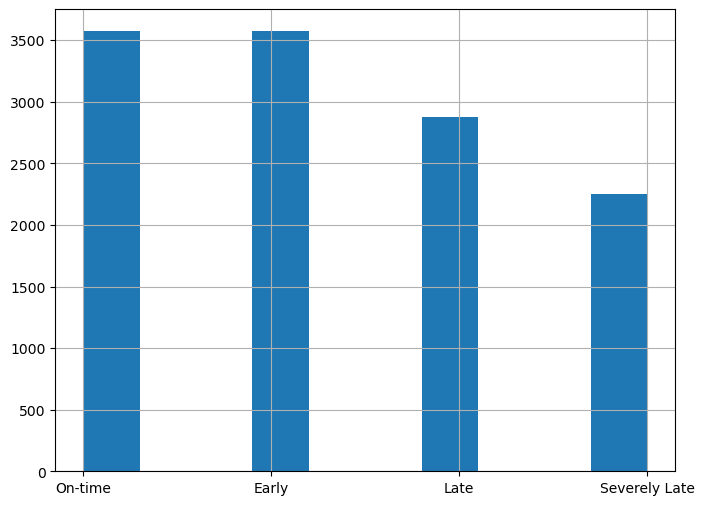

Length of flight data:  20352
Length of merged data:  12275
Total NaN values:  0


In [28]:
fig, ax = plt.subplots(figsize=(8, 6))
data['Status'].hist(ax=ax)
plt.show()

print("Length of flight data: ", len(flight_data))
print("Length of merged data: ", len(data))
print("Total NaN values: ", data.isna().sum().sum())

# One Hot Encoding

In [29]:
# One-hot encode categorical variables
data = pd.get_dummies(data, columns=['Origin Airport'])

# Split data into testing and training

In [30]:
X = data.drop(columns=['Status'])
y = data['Status']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print the length of the train and test data
print("Length of train dataset: ", len(X_train))
print("Length of test dataset: ", len(X_test))

Length of train dataset:  9820
Length of test dataset:  2455


# Normalize data

In [31]:
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Show 10 rows of the dataframe
X_train.head(10)

,Actual Elapsed Time (Minutes),origin_temperature_2m (°C),origin_relativehumidity_2m (%),origin_dewpoint_2m (°C),origin_apparent_temperature (°C),origin_pressure_msl (hPa),origin_surface_pressure (hPa),origin_precipitation (mm),origin_rain (mm),origin_snowfall (cm),...,destination_windspeed_100m (km/h),destination_winddirection_10m (°),destination_winddirection_100m (°),destination_windgusts_10m (km/h),destination_et0_fao_evapotranspiration (mm),destination_vapor_pressure_deficit (kPa),Origin Airport_DEN,Origin Airport_EWR,Origin Airport_IAD,Origin Airport_ORD
5913,0.27,0.52,0.52,0.53,0.47,0.55,0.83,0.00,0.00,0.00,...,0.31,0.83,0.83,0.19,0.04,0.11,0.00,0.00,0.00,1.00
17018,0.22,0.72,0.75,0.82,0.71,0.60,0.85,0.00,0.00,0.00,...,0.10,0.99,0.99,0.14,0.22,0.17,0.00,0.00,0.00,1.00
16881,0.23,0.59,0.60,0.63,0.55,0.41,0.79,0.00,0.00,0.00,...,0.23,0.37,0.37,0.29,0.22,0.13,0.00,0.00,0.00,1.00
9461,0.28,0.75,0.40,0.72,0.69,0.55,0.83,0.00,0.00,0.00,...,0.39,0.87,0.87,0.46,0.27,0.19,0.00,0.00,0.00,1.00
16504,0.27,0.70,0.48,0.71,0.65,0.55,0.83,0.00,0.00,0.00,...,0.15,0.36,0.39,0.08,0.00,0.06,0.00,0.00,0.00,1.00
2984,0.22,0.45,0.82,0.54,0.43,0.40,0.78,0.00,0.00,0.00,...,0.07,0.36,0.28,0.07,0.00,0.03,0.00,0.00,0.00,1.00
3290,0.21,0.42,0.62,0.46,0.38,0.48,0.80,0.00,0.00,0.00,...,0.40,0.73,0.74,0.31,0.01,0.00,0.00,0.00,0.00,1.00
6219,0.21,0.57,0.74,0.64,0.54,0.43,0.79,0.01,0.01,0.00,...,0.39,0.78,0.77,0.43,0.16,0.07,0.00,0.00,0.00,1.00
55,0.23,0.35,0.56,0.37,0.32,0.52,0.81,0.00,0.00,0.00,...,0.39,0.70,0.70,0.34,0.01,0.03,0.00,0.00,0.00,1.00
9442,0.25,0.82,0.72,0.92,0.81,0.40,0.79,0.00,0.00,0.00,...,0.31,0.62,0.62,0.33,0.49,0.28,0.00,0.00,0.00,1.00


# Training

In [32]:
model = RandomForestClassifier(class_weight=None, max_depth=6, max_features='sqrt', min_samples_leaf=4,
                               n_estimators=100, random_state=50, warm_start=True)
model.fit(X_train, y_train)

# Evaluate model on training and testing sets
y_train_pred = model.predict(X_train)

# Calculate the accuracy score (R-square)
print("Train R^2 score: ", round(model.score(X_train, y_train), 2))
print("Test R^2 score: ", round(model.score(X_test, y_test), 2))

RandomForestClassifier(max_depth=6, max_features='sqrt', min_samples_leaf=4,
                       random_state=50, warm_start=True)

Train R^2 score:  0.58
Test R^2 score:  0.53


# Testing

In [33]:
# # Define the parameter grid for the grid search
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [2, 3, 4, 5, 6],
#     'min_samples_leaf': [1, 2, 3, 4],
#     'max_features': ['sqrt', 'log2'],
#     'class_weight': ['balanced', 'balanced_subsample', None],
#     'warm_start': [True, False],
#     'random_state': [50]
# }
#
# # Initialize the RandomForestRegressor model with a random state for reproducibility
# model = RandomForestClassifier()
#
# # Set up the GridSearchCV object with the model, parameter grid, scoring function,
# # number of cross-validation folds (cv=3), and use all available CPU cores (n_jobs=-1)
# grid_search = GridSearchCV(model, param_grid, cv=3, n_jobs=-1)
#
# # Fit the grid search object to the training data
# grid_search.fit(X_train, y_train)
#
# # Print the best combination of parameters found by the grid search
# print("Best parameters found: ", grid_search.best_params_)
#
# print("Best score found: ", grid_search.best_score_)

#

In [34]:
# Create a dataframe to store the results
test_output = pd.DataFrame({'actual': y_test, 'predicted': model.predict(X_test)})

# Display the first 10 rows
test_output.head(10)

,actual,predicted
9120,Severely Late,On-time
15157,Early,Late
4057,Late,On-time
4055,Late,Early
16903,Early,Severely Late
9210,On-time,Severely Late
15649,Severely Late,On-time
12591,Late,Early
9271,Severely Late,Late
6695,On-time,Early


<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'Ground truth')

Text(0.5, 1.0, 'Predictions')

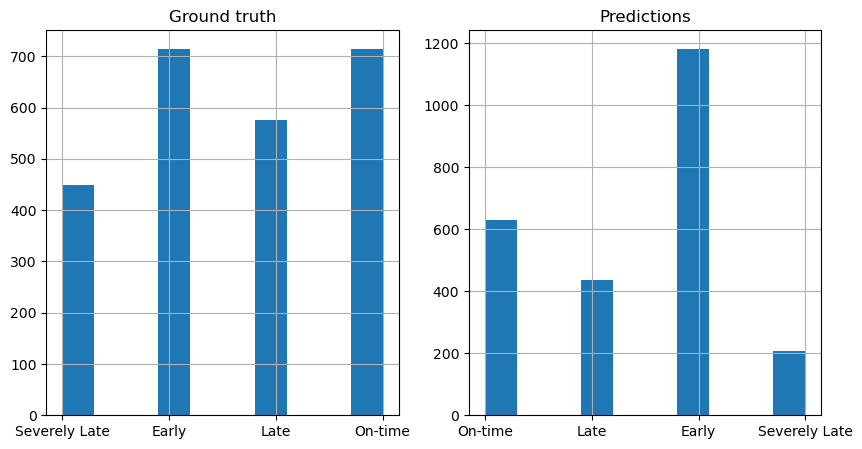

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
test_output.actual.hist(ax=ax[0])
test_output.predicted.hist(ax=ax[1])
ax[0].set_title('Ground truth')
ax[1].set_title('Predictions')
plt.show()